# Electric motor temperature estimation

## In this notebook:
- **About the dataset**
    - Background
    - Inspiration
    - Dataset characteristics
    - License
- **Theory**
    - Construction of a synchronous motor
    - Parks transformation
- **Project**
    - Libraries
    - Loading data
    - Data analysis
    - Visualisation
    - Correlation heatmap
    - Molding data
    - Splitting data
    - Building the model
    - Model evaluation
    - Application of moving average
    - Saving the model
    - Conclusion

        


# About the dataset


### Background

The data set comprises several sensor data collected from a permanent magnet synchronous motor (PMSM) deployed on a test bench. The PMSM represents a german OEM's prototype model. Test bench measurements were collected by the LEA department at Paderborn University.
This data set is mildly anonymized.

The motor is excited by hand-designed driving cycles denoting a reference motor speed and a reference torque.
Currents in d/q-coordinates (columns "id" and iq") and voltages in d/q-coordinates (columns "ud" and "uq") are a result of a standard control strategy trying to follow the reference speed and torque.
Columns "motor_speed" and "torque" are the resulting quantities achieved by that strategy, derived from set currents and voltages.

Most driving cycles denote random walks in the speed-torque-plane in order to imitate real world driving cycles to a more accurate degree than constant excitations and ramp-ups and -downs would.

## Inspiration

The most interesting target features are rotor temperature ("pm"), stator temperatures ("stator_*") and torque.
Especially rotor temperature and torque are not reliably and economically measurable in a commercial vehicle.

Being able to have strong estimators for the rotor temperature helps the automotive industry to manufacture motors with less material and enables control strategies to utilize the motor to its maximum capability.
A precise torque estimate leads to more accurate and adequate control of the motor, reducing power losses and eventually heat build-up.

### Dataset characteristics
All recordings are sampled at 2 Hz. The data set consists of multiple measurement sessions, which can be distinguished from each other by column "profile_id". A measurement session can be between one and six hours long.
	
- ambient: ambient temperature as measured by a thermal sensor located closely to the stator,
- coolant : coolant temperature, the motor is water cooled, measurement is taken at outflow,
- u_d : voltage d-component,
- u_q : voltage q-component,
- motor_speed : motor speed,
- torque : torque induced by current,
- i_d : current d-component,
- i_q : current q-component,
- PM : Permanent Magnet surface temperature representing the rotor temperature measured with an infrared,
- stator_yoke : stator yoke temperature measured with a thermal sensor,
- stator_tooth : stator tooth temperature measured with a thermal sensor,
- stator_winding : stator winding temperature measured with a thermal sensor,
- profile_id : measurment session


### License
Please cite the following publications if you intend to use this dataset for your own publications:

[Deep Residual Convolutional and Recurrent Neural Networks for Temperature Estimation in Permanent Magnet Synchronous Motors
Code available on wkirgsn github/deep-pmsm](https://www.researchgate.net/publication/331982128_Deep_Residual_Convolutional_and_Recurrent_Neural_Networks_for_Temperature_Estimation_in_Permanent_Magnet_Synchronous_Motors)

[Empirical Evaluation of Exponentially Weighted Moving Averages for Simple Linear Thermal Modeling of Permanent Magnet Synchronous Machines](https://www.researchgate.net/publication/331976678_Empirical_Evaluation_of_Exponentially_Weighted_Moving_Averages_for_Simple_Linear_Thermal_Modeling_of_Permanent_Magnet_Synchronous_Machines)

The dataset comes from [Kaggle](https://www.kaggle.com/wkirgsn/electric-motor-temperature)




# Theory

## Construction of a synchronous motor

Stator is stationary part, yoke is the outer covering of the machine. The stator winding of a synchronous machine is similar to the stator winding of an induction machine, it consists of interwoven wire. The rotor rotates with the rotating field created by the stator winding. The excitation winding creates stationary rotating magnetic field.

![Image](https://i.imgur.com/xK3nGsS.png)[source](http://rine.bdel.mohammedshrine.org/ac-synchronous-motor-3-phase-wiring-diagram.html)

## Parks transformation

The synchronous generator is modeled using the Park transformation. After the transformation of the machine equation, previously written in phase coordinates are presented in the new "d, q" coordinate system. In that case each of the stator winding coils corresponding to the winding phase is replaced by two coils d, q, which rotate synchronously with the rotor rotation.
 

![Image](https://i.imgur.com/LhLgHO9.png)

The Park transformation matrix T:![Image](https://i.imgur.com/EgGmVpo.png)

This matrix is orthogonal: ![Image](https://i.imgur.com/rIxaeJp.png)

The stator voltage and current vectors after the Park transformation: ![Image](https://i.imgur.com/kInEtUz.png)

# Project

The goal of this project is to build a model that estimates temperature of electric motor with at least 90% accuarcy.

### Libraries

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import bottleneck as bn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score
import pickle

%matplotlib inline

### Loading data

In [2]:
df = pd.read_csv("./data/pmsm_temperature_data.csv")

In [3]:
df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


### Data analysis

In [4]:
df.isnull().values.any()

False

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ambient,998070.0,-0.003905,0.993127,-8.573954,-0.599385,0.266157,0.686675,2.967117
coolant,998070.0,0.004723,1.002423,-1.429349,-1.037925,-0.177187,0.650709,2.649032
u_d,998070.0,0.004780,0.997878,-1.655373,-0.826359,0.267542,0.358491,2.274734
u_q,998070.0,-0.005690,1.002330,-1.861463,-0.927390,-0.099818,0.852625,1.793498
motor_speed,998070.0,-0.006336,1.001229,-1.371529,-0.951892,-0.140246,0.853584,2.024164
torque,998070.0,-0.003333,0.997907,-3.345953,-0.266917,-0.187246,0.547171,3.016971
i_d,998070.0,0.006043,0.998994,-3.245874,-0.756296,0.213935,1.013975,1.060937
i_q,998070.0,-0.003194,0.997912,-3.341639,-0.257269,-0.190076,0.499260,2.914185
pm,998070.0,-0.004396,0.995686,-2.631991,-0.672308,0.094367,0.680691,2.917456
stator_yoke,998070.0,0.000609,1.001049,-1.834688,-0.747265,-0.057226,0.697344,2.449158


There are no missing values in this dataset. In table above we can see many useful metrics of this dataset. Before molding data and building neural network it is important to take a loot at data and visualise it. Plots beneath have been created to give us better understanding what we're dealing with.

### Visualisation

In [6]:
list = df["profile_id"].unique()
list.sort()
print("Unique profiles: {}".format(list))

Unique profiles: [ 4  6 10 11 20 27 29 30 31 32 36 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77
 78 79 80 81]


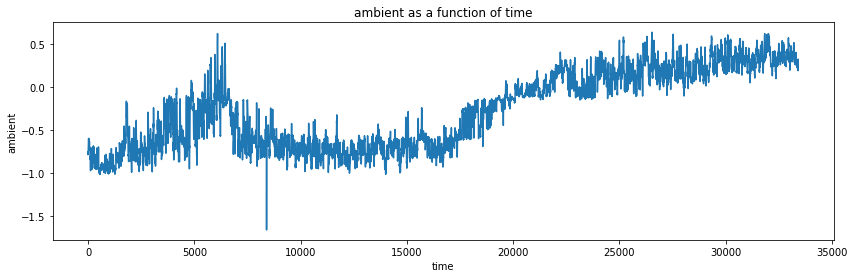

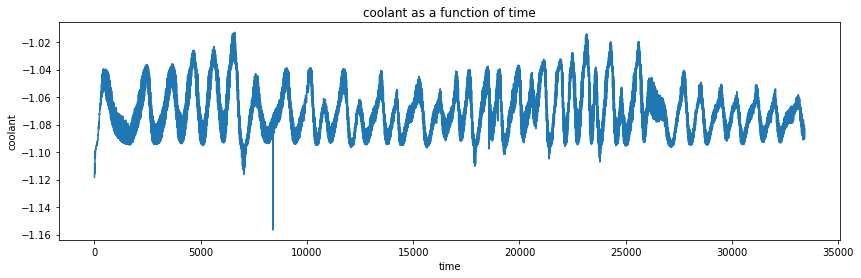

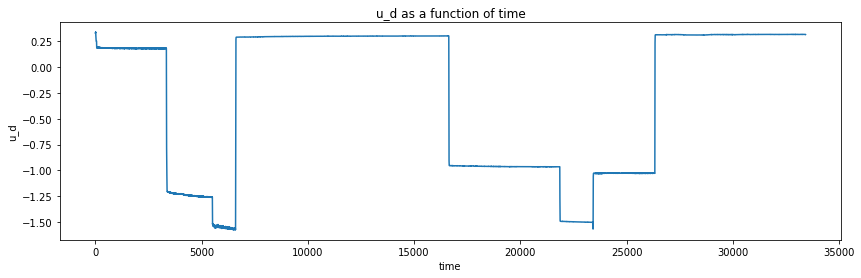

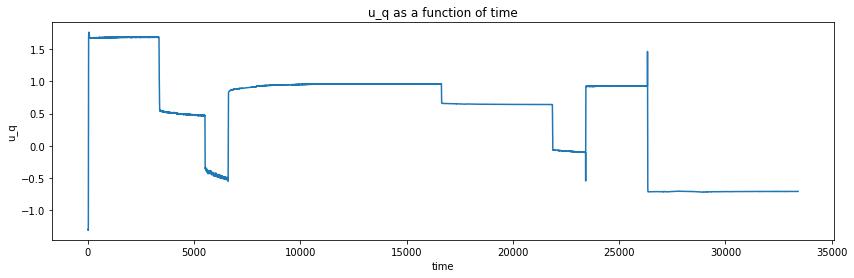

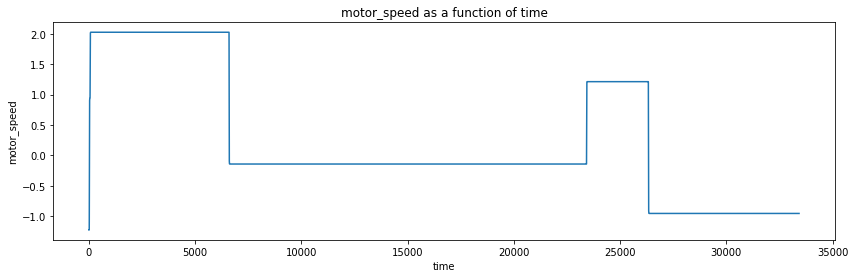

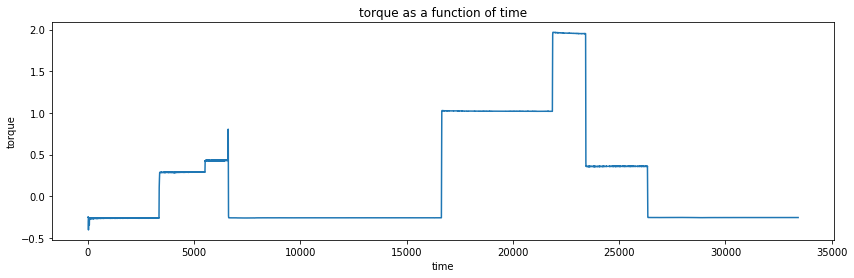

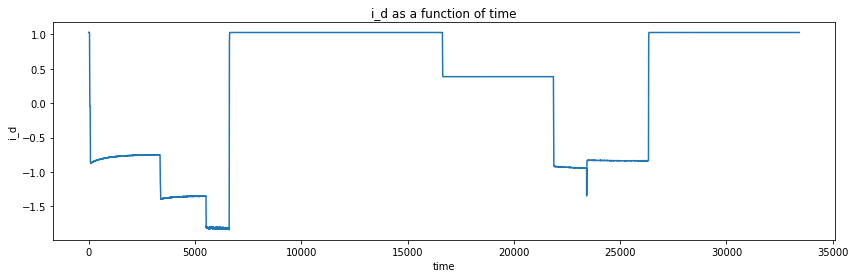

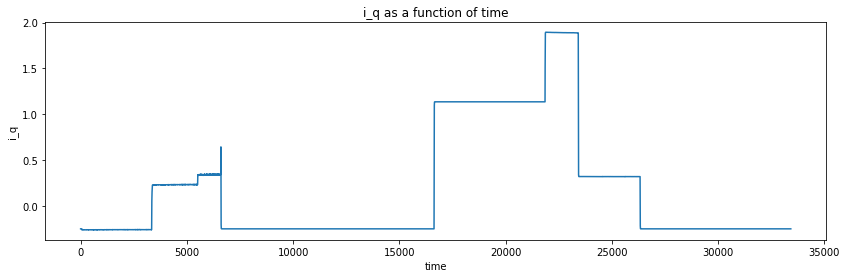

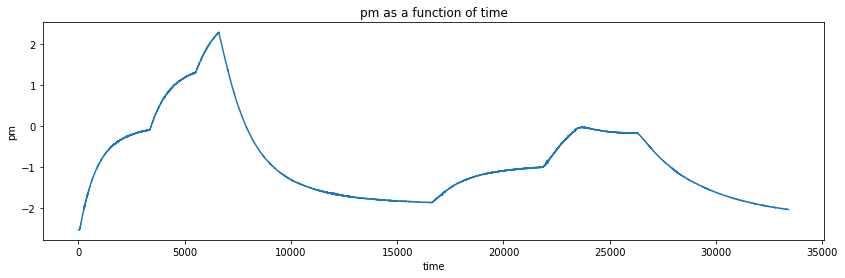

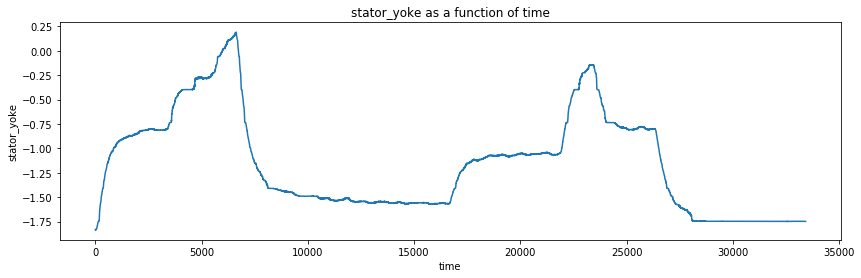

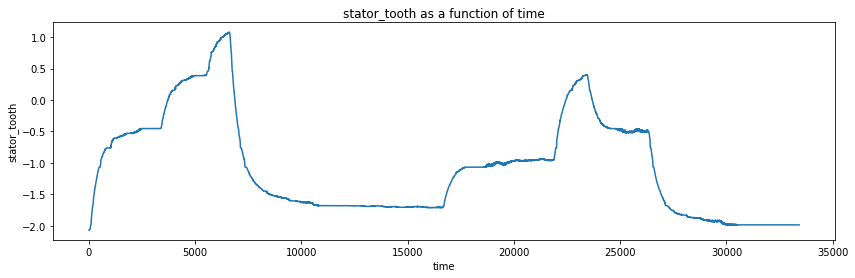

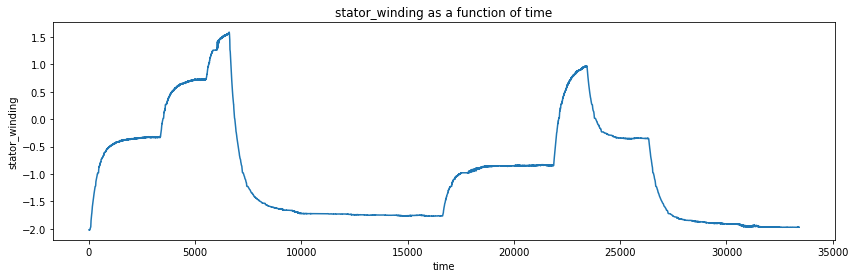

In [7]:
columns = df.columns
profile_id = np.array(df["profile_id"])

for column in columns[:-1]:

    figure = plt.figure(figsize=(14,4))
    ax = plt.gca()
    ax.plot(df.index.values[profile_id==4], df[column][profile_id==4])
    ax.set_xlabel("time")
    ax.set_ylabel(column)
    ax.set_title("{} as a function of time".format(column))

    plt.show()

[Text(0, 0.5, 'Stator winding temperature')]

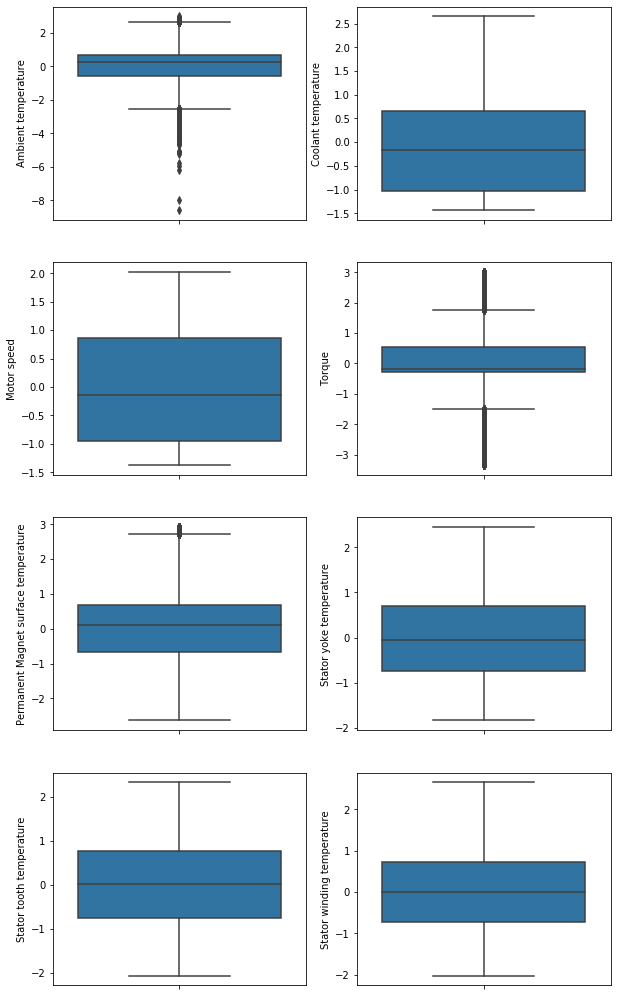

In [8]:
fig, axes = plt.subplots(nrows=4,ncols=2)
fig.set_size_inches(10, 18)

sns.boxplot(x="ambient", data=df, orient="v", ax=axes[0][0])
sns.boxplot(x="coolant", data=df, orient="v", ax=axes[0][1])
sns.boxplot(x="motor_speed", data=df, orient="v", ax=axes[1][0])
sns.boxplot(x="torque", data=df, orient="v", ax=axes[1][1])
sns.boxplot(x="pm", data=df, orient="v", ax=axes[2][0])
sns.boxplot(x="stator_yoke", data=df, orient="v", ax=axes[2][1])
sns.boxplot(x="stator_tooth", data=df, orient="v", ax=axes[3][0])
sns.boxplot(x="stator_winding", data=df, orient="v", ax=axes[3][1])


axes[0][0].set(ylabel='Ambient temperature')
axes[0][1].set(ylabel='Coolant temperature')
axes[1][0].set(ylabel='Motor speed')
axes[1][1].set(ylabel='Torque')
axes[2][0].set(ylabel='Permanent Magnet surface temperature')
axes[2][1].set(ylabel='Stator yoke temperature')
axes[3][0].set(ylabel='Stator tooth temperature')
axes[3][1].set(ylabel='Stator winding temperature')

### Correlation heatmap

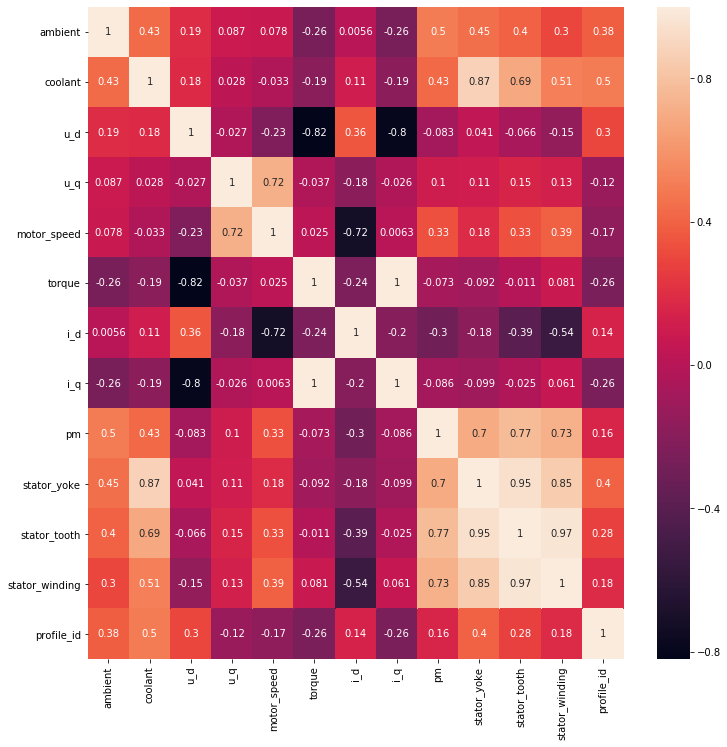

In [9]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(),annot=True) # df2.corr() makes a correlation matrix, sns.heatmap creates heatmap of values
plt.show()

### Molding data

In [10]:
del df["torque"]
del df["stator_winding"]
del df["stator_tooth"]
del df["stator_yoke"]

### Splitting data

In [11]:
feature_col_names = ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q', 'profile_id' ]
predicted_class_names = ["pm"]

X = df[feature_col_names].values 
y = df[predicted_class_names].values 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=40)

### Building the model

In [12]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 10, random_state = 0)
model.fit(X_train, y_train.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

### Model evaluation

In [13]:
predictions = model.predict(X_test)
print("Mean Absolute Error:         {0:0.2f}".format(mean_absolute_error(y_test,predictions)))
print("Mean Squared Error:          {0:0.2f}".format((mean_squared_error(y_test,predictions))))
print("Explained Variance Score:    {0:0.2f}%".format(explained_variance_score(y_test,predictions)*100))

Mean Absolute Error:         0.03
Mean Squared Error:          0.01
Explained Variance Score:    99.16%


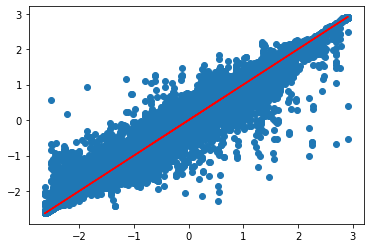

In [14]:
# Our predictions
plt.scatter(y_test,predictions)

# Perfect predictions
plt.plot(y_test,y_test,'r')

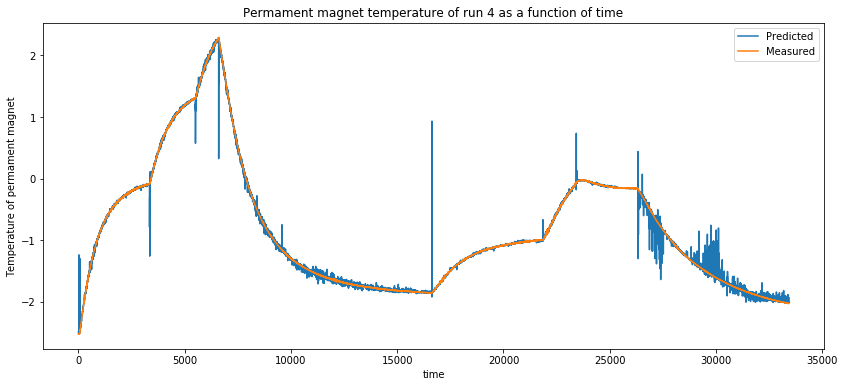

In [29]:
figure = plt.figure(figsize=(14,6))
test_run = 4

plt.plot(df.index.values[profile_id==test_run], model.predict(df[feature_col_names].values[profile_id==test_run]), label = "Predicted")
plt.plot(df.index.values[profile_id==test_run], df["pm"][profile_id==test_run], label = "Measured")
plt.legend()
plt.xlabel("time")
plt.ylabel("Temperature of permament magnet")
plt.title("Permament magnet temperature of run {} as a function of time".format(test_run))

plt.show()

### Application of moving average

In [39]:
predictions_test_smooth = bn.move_mean(model.predict(df[feature_col_names].values[profile_id==test_run]),100,1)
measured_test = df["pm"][profile_id==test_run]
print("Mean Absolute Error:         {0:0.2f}".format(mean_absolute_error(measured_test,predictions_test_smooth)))
print("Mean Squared Error:          {0:0.2f}".format((mean_squared_error(measured_test,predictions_test_smooth))))
print("Explained Variance Score:    {0:0.2f}%".format(explained_variance_score(measured_test,predictions_test_smooth)*100))

Mean Absolute Error:         0.02
Mean Squared Error:          0.00
Explained Variance Score:    99.90%


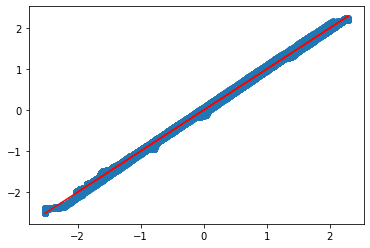

In [40]:
# Our predictions
plt.scatter(measured_test,predictions_test_smooth)

# Perfect predictions
plt.plot(measured_test,measured_test,'r')

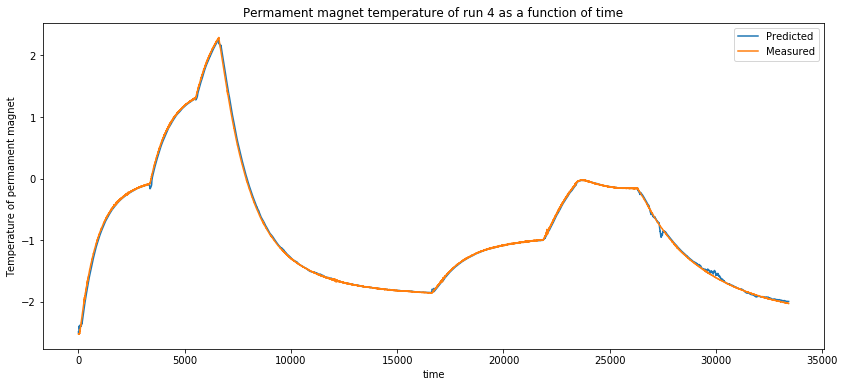

In [41]:
figure = plt.figure(figsize=(14,6))

plt.plot(df.index.values[profile_id==test_run], predictions_test_smooth, label = "Predicted")
plt.plot(df.index.values[profile_id==test_run], measured_test, label = "Measured")
plt.legend()
plt.xlabel("time")
plt.ylabel("Temperature of permament magnet")
plt.title("Permament magnet temperature of run {} as a function of time".format(test_run))

plt.show()

## Saving the model

In [43]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

# Conclusion
In this project I've built model that estimates temperaturte of permament magnet in the rotor. With this model user can know temperature of the motor without taking measurment. This reduces cost, helps create more optimal motors and protects equipment from overheating.